In [20]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import KNN
from esda import Moran, G_Local
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

In [9]:
df = pd.read_csv("../../data/final/8_Apis_cerana_with_nearby_species.csv")
df1 = pd.read_csv("../../data/final/8_Apis_mellifera_with_nearby_species.csv")

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]))
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs("EPSG:3857")

In [10]:
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1["Longitude"], df1["Latitude"]))
gdf1.crs = "EPSG:4326"
gdf1 = gdf1.to_crs("EPSG:3857")

### 1. 공간 가중치 생성 (KNN)

In [5]:
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
knn = KNN.from_array(coords, k=8)

c:\.Soyeon\BeeDisease\bee_env\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [11]:
coords1 = list(zip(gdf1.geometry.x, gdf1.geometry.y))
knn1 = KNN.from_array(coords1, k=8)

### 2. Getis-Ord Gi* (Hotspot 분석)

In [6]:
gi_star = G_Local(gdf["발생두수"], knn)

gdf["GiZ"] = gi_star.Zs

In [12]:
gi_star1 = G_Local(gdf1["발생두수"], knn1)

gdf1["GiZ"] = gi_star1.Zs

### 3. 시각화

<Figure size 1000x600 with 0 Axes>

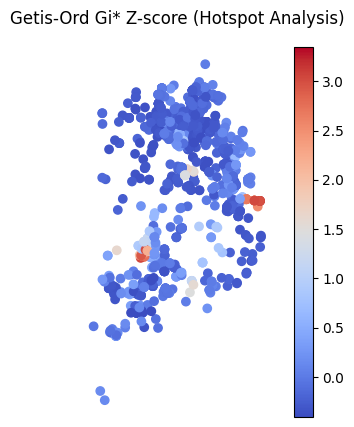

In [7]:
plt.figure(figsize=(10, 6))
gdf.plot(column="GiZ", cmap="coolwarm", legend=True)
plt.title("Getis-Ord Gi* Z-score (Hotspot Analysis)")
plt.axis("off")
plt.show()

<Figure size 1000x600 with 0 Axes>

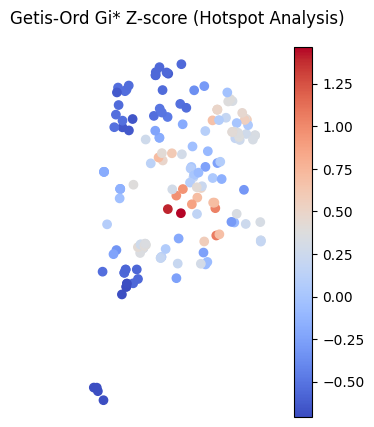

In [13]:
plt.figure(figsize=(10, 6))
gdf1.plot(column="GiZ", cmap="coolwarm", legend=True)
plt.title("Getis-Ord Gi* Z-score (Hotspot Analysis)")
plt.axis("off")
plt.show()

### 4. Moran’s I

In [8]:
moran_i = Moran(gdf["발생두수"], knn)

print(f"Moran's I: {moran_i.I:.4f}")
print(f"p-value: {moran_i.p_sim:.4f}")

Moran's I: 0.2257
p-value: 0.0010


In [14]:
moran_i1 = Moran(gdf1["발생두수"], knn1)

print(f"Moran's I: {moran_i1.I:.4f}")
print(f"p-value: {moran_i1.p_sim:.4f}")

Moran's I: 0.0847
p-value: 0.0120


### 결과 해석

각 군집의 Z-score를 시각화한 것으로, 

GiZ > 1.96 (~ 빨간색): 유의미한 Hotspot (감염도가 높고, 주변도 높음)

GiZ < -1.96 (~ 진한 파란색): 유의미한 Coldspot (감염도 낮고, 주변도 낮음)

0에 가까운 값: 공간적 특이성 없음

대부분의 지역이 파란색 계열 → Coldspot, 즉 감염도가 낮은 지역이 주변과 함께 퍼져 있음

중앙 및 남부 일부 지역에 주황/빨간색 군집이 존재: 감염도가 높고, 그 주변도 함께 높은 지역 → 감염 Hotspot으로 해석됨. 중앙부 남쪽, 중앙 오른쪽.

$\Rightarrow$ 일부 지역 Hotspot 존재,	감염도 높은 지역이 국지적으로 집중되어 있음

Moran's I > 0 $\rightarrow$ 감염 개체 수가 공간적으로 양의 자기상관을 가짐

p-value < 0.05 $\rightarrow$	이 자기상관이 통계적으로 유의함

$\Rightarrow$ 감염 개체 수가 많은 군집들은 지리적으로 가까운 위치에 함께 몰려 있고, 감염이 낮은 군집도 서로 가까이 모여 있다는 것을 의미

### 공간 회귀

In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap
from libpysal.weights import KNN
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

Global R2: 0.2827
Bandwidth used: 70.0


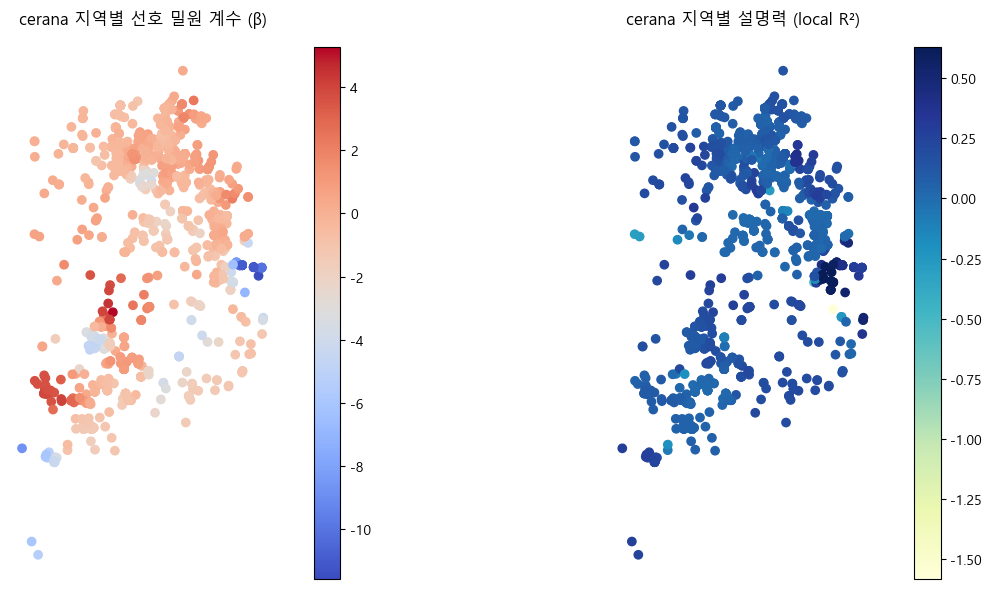

In [27]:
cerana_preferred = {'밤나무', '산밤나무', '약밤나무', '배추', '유채', '머귀나무',
                    '왕초피', '초피나무', '산초나무', '벼', '피마자'}
common_preferred = {'다래', '쥐다래', '개다래', '섬다래',
                    '감나무', '고욤나무', '개옺나무', '검양옺나무', '산검양옺나무',
                    '옺나무', '붉나무', '광대싸리'}
cerana_pref = cerana_preferred | common_preferred

# nearby 밀원 종 세트 생성
def extract_species_set(row):
    return {row[col] for col in row.index if col.startswith("nearby_") and pd.notna(row[col])}

df["species_set"] = df.apply(extract_species_set, axis=1)

# 선호종 수 계산
df["preferred_count"] = df["species_set"].apply(lambda s: len(s & cerana_pref))

# 좌표 및 공간 객체
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]))
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs("EPSG:3857")  # 거리 단위 계산 위해 투영

# -------------------------------
# 2. GWR 분석 준비
# -------------------------------
y = df[["발생두수"]].values  # 종속변수
X = df[["preferred_count"]].values  # 독립변수
u = gdf.geometry.x.values  # X좌표
v = gdf.geometry.y.values  # Y좌표
coords = np.column_stack([u, v])

# 최적 대역폭 선택
bw = Sel_BW(coords, y, X).search()

# GWR 모델 학습
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# -------------------------------
# 3. 결과 확인
# -------------------------------
df["GWR_beta"] = gwr_results.params[:, 1]  # 독립변수에 대한 지역별 계수
df["GWR_local_R2"] = gwr_results.localR2  # 지역별 설명력

print(f"Global R2: {gwr_results.R2:.4f}")
print(f"Bandwidth used: {bw}")

# -------------------------------
# 4. 시각화
# -------------------------------
gdf["GWR_beta"] = df["GWR_beta"]
gdf["GWR_local_R2"] = df["GWR_local_R2"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
gdf.plot(column="GWR_beta", cmap="coolwarm", legend=True, ax=ax[0])
ax[0].set_title("cerana 지역별 선호 밀원 계수 (β)")
ax[0].axis("off")

gdf.plot(column="GWR_local_R2", cmap="YlGnBu", legend=True, ax=ax[1])
ax[1].set_title("cerana 지역별 설명력 (local R²)")
ax[1].axis("off")

plt.tight_layout()
plt.savefig("../../outputs/figures/S_2_1_Spatial_statistics_cerana.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
print(df["발생두수"].describe())

count    1159.000000
mean       11.094047
std        24.990305
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max       360.000000
Name: 발생두수, dtype: float64


Global R²: 0.2315
Bandwidth used: 50.0


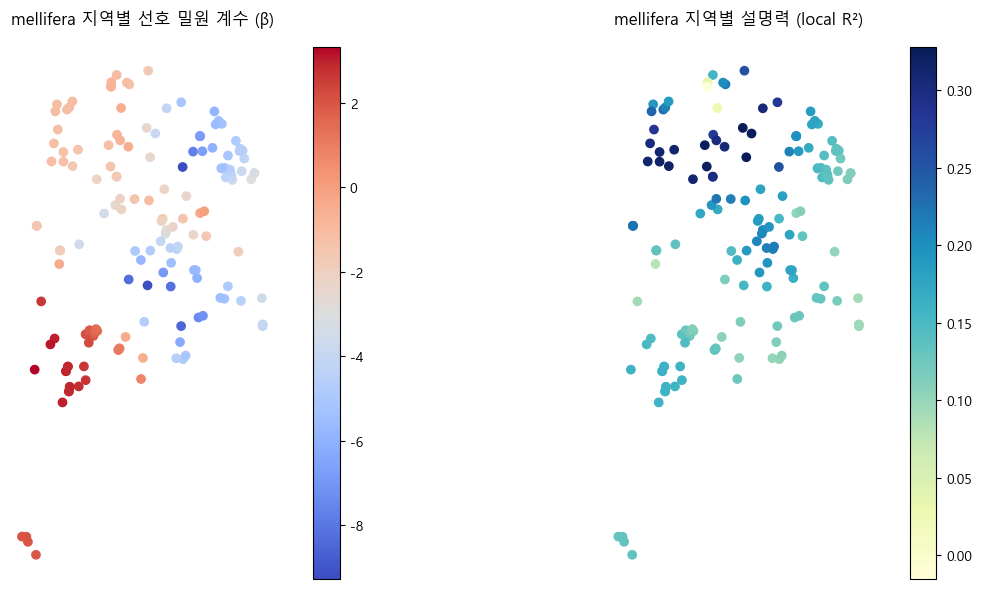

In [28]:
mellifera_preferred = {
    '족제비싸리', '아까지나무', '갈참나무', '굴참나무', '떡갈나무', '종가시나무',
    '물참나무', '상수리나무', '신갈나무', '졸참나무', '가시나무', '붉가시나무',
    '갈졸참나무', '떡갈참나무', '떡신갈나무', '주름잎', '누운주름잎', '덩굴장미',
    '목향장미', '생열귀나무', '용가시나무', '인가목', '해당화', '고추', '애기똥풀'
}
common_preferred = {
    '다래', '쥐다래', '개다래', '섬다래',
    '감나무', '고욤나무', '개옺나무', '검양옺나무', '산검양옺나무',
    '옺나무', '붉나무', '광대싸리'
}
mellifera_pref = mellifera_preferred | common_preferred

def extract_species_set(row):
    return {row[col] for col in row.index if col.startswith("nearby_") and pd.notna(row[col])}

df1["species_set"] = df1.apply(extract_species_set, axis=1)

# 선호종 수 계산
df1["preferred_count"] = df1["species_set"].apply(lambda s: len(s & mellifera_pref))



gdf = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1["Longitude"], df1["Latitude"]))
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs("EPSG:3857")  # 거리 기반 투영



y = df1[["발생두수"]].values
X = df1[["preferred_count"]].values
u = gdf.geometry.x.values
v = gdf.geometry.y.values
coords = np.column_stack([u, v])

# 최적 대역폭 선택
bw = Sel_BW(coords, y, X).search()

# GWR 모델 학습
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()



df1["GWR_beta"] = gwr_results.params[:, 1]
df1["GWR_local_R2"] = gwr_results.localR2

print(f"Global R²: {gwr_results.R2:.4f}")
print(f"Bandwidth used: {bw}")



gdf["GWR_beta"] = df1["GWR_beta"]
gdf["GWR_local_R2"] = df1["GWR_local_R2"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
gdf.plot(column="GWR_beta", cmap="coolwarm", legend=True, ax=ax[0])
ax[0].set_title("mellifera 지역별 선호 밀원 계수 (β)")
ax[0].axis("off")

gdf.plot(column="GWR_local_R2", cmap="YlGnBu", legend=True, ax=ax[1])
ax[1].set_title("mellifera 지역별 설명력 (local R²)")
ax[1].axis("off")

plt.tight_layout()
plt.savefig("../../outputs/figures/S_2_1_Spatial_statistics_mellifera.png", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
print(df1["발생두수"].describe())

count    160.000000
mean      69.068750
std       96.792531
min        1.000000
25%        2.000000
50%       30.000000
75%       90.000000
max      500.000000
Name: 발생두수, dtype: float64
